In [95]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [3]:
paths = []
y = []

DATASET_PATH = 'data'

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.wav'):
            parts = file.split('-')
            emotion_code = parts[2]
            emotion_label = emotion_map.get(emotion_code)
            filepath = os.path.join(root, file)
            paths.append(filepath)
            y.append(emotion_label)


In [4]:
import librosa as lr
import numpy as np

def extract_feature(file_path):
    # Load audio file, convert to mono, resample for speed
    audio, sample_rate = lr.load(file_path)

    # 🎤 MFCCs (Mel-Frequency Cepstral Coefficients)
    # Describes *how* the sound feels to the ear — tone & texture.
    mfccs = np.mean(lr.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0)

    # 🔊 Energy (Root Mean Square)
    # Measures how loud or intense the voice is.
    energy = np.mean(lr.feature.rms(y=audio).T, axis=0)

    # 🎼 Chroma STFT (Short-Time Fourier Transform)
    # Captures pitch class (like musical notes); useful for emotion in melodic speech.
    chroma = np.mean(lr.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)

    # ⏱️ Tempo (from Tempogram)
    # Captures speed/rhythm of the speech — faster may mean excitement or stress.
    tempo_val, _ = lr.beat.beat_track(y=audio, sr=sample_rate)
    tempo = np.array([tempo_val])

    # ⚡ Zero Crossing Rate
    # Counts how often the signal changes sign — chaotic speech = more crossings.
    zcr = np.mean(lr.feature.zero_crossing_rate(y=audio).T, axis=0)

    # 📍 Spectral Centroid
    # Tells where the "center of mass" of the sound spectrum is — higher = brighter sound.
    centroid = np.mean(lr.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0)

    # 📏 Spectral Bandwidth
    # Measures the width of the spectrum — more emotion = wider bandwidth.
    bandwidth = np.mean(lr.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0)

    # 🌈 Spectral Contrast
    # Captures the difference between peaks and valleys in the spectrum — useful for timbre/emotion.
    contrast = np.mean(lr.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)

    # 🪞 Spectral Flatness
    # Measures noisiness — flat = noise-like, sharp = tonal.
    flatness = np.mean(lr.feature.spectral_flatness(y=audio).T, axis=0)

    # 🎚️ Spectral Rolloff
    # Frequency below which most of the energy is contained — relates to tone sharpness.
    rolloff = np.mean(lr.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0)

    # 🔮 Tonnetz (Tonal Centroid)
    # Advanced pitch features — captures harmonic relations; good for emotional musicality in voice.
    tonnetz = np.mean(lr.feature.tonnetz(y=lr.effects.harmonic(audio), sr=sample_rate).T, axis=0)

    # 🧠 Combine all features into a single vector
    return np.hstack([
        mfccs,         # 13 values
        energy,        # 1 value
        chroma,        # 12 values
        tempo.flatten(),         # ~384 values — careful: this one’s BIG
        zcr,           # 1 value
        centroid,      # 1 value
        bandwidth,     # 1 value
        contrast,      # 7 values
        flatness,      # 1 value
        rolloff,       # 1 value
        tonnetz        # 6 values
    ])


In [5]:
all_features = []

for i in range(len(paths)):
    file_path = paths[i]
    features = extract_feature(file_path)
    all_features.append(features)

# Convert list of arrays into a DataFrame
features_df = pd.DataFrame(all_features, columns=[f'feature_{i}' for i in range(len(all_features[0]))])

features_df['path'] = paths
features_df['emotion'] = y

df = features_df

# Save it
df.to_csv('ravdess_labels.csv', index=False)

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


In [31]:
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# y_encoded = one_hot_encoder.fit_transform(df[['emotion']])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['emotion'])

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns=['path', 'emotion']),
    y_encoded,
    test_size=0.2,
    random_state=42
)

In [33]:
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [96]:
model = Sequential([
    Input(shape=(x_train.shape[1],)),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
    # Dropout(0.1),

    Dense(256, activation='relu'),
    # Dropout(0.1),

    Dense(128, activation='relu'),
    Dropout(0.1),

    Dense(len(emotion_map), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_sc, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])

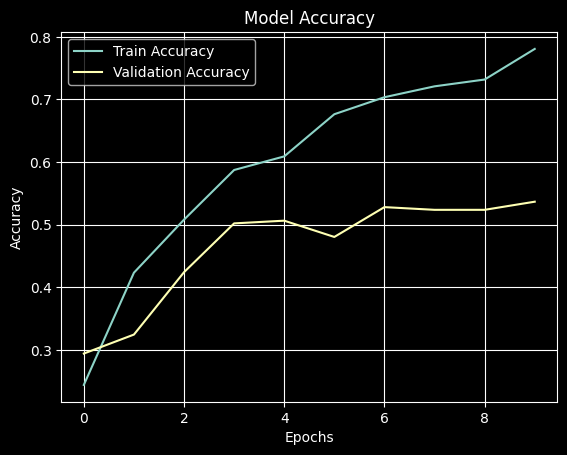

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()